# <center>Fuzzy Clustering</center>
## <center>Inclass Project 1 - MA4144</center>

This project contains 9 tasks/questions to be completed, some require written answers. Open markdow cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

Use this cell to use any include any imports

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
import itertools

**Q1.** In the following cell load the data (in the file SMDataRefined.csv) to a pandas dataframe, and display the data. Then get the data into a numpy matrix $X$, each row corresponding to a datapoint and each column to a feature, in our case whether a certain token exists ($1$) or not ($0$). Let us denote the number of rows of $X$ by $N$ and the number of columns by $M$.

**About the dataset**: Each row in the dataset refers to a social media post. The first column refers to the number of likes received by each post (standardized between to the interval $[0, 1]$), the columns after that will denote the presence of a certain word (token) in the text of the post. For example, a $1$ in the column "TextToken_life" denotes that the particular post contained the word "life" in it and $0$ otherwise. These will be the features of our dataset. Our aim is to cluster these social media posts based on number of likes and words contained in it.

In [217]:
dataframe = pd.read_csv('C:/Users/ASUS VivoBook/OneDrive - University of Moratuwa/Desktop/neural networks project/SMDataRefined.csv')
print(dataframe)

        Likes  TextToken_life  TextToken_joy  TextToken_night  \
0    0.285714               0              0                0   
1    0.000000               0              0                0   
2    0.428571               0              0                0   
3    0.071429               0              0                0   
4    0.214286               0              0                0   
..        ...             ...            ...              ...   
727  0.414286               0              0                0   
728  0.542857               0              0                0   
729  0.457143               0              1                0   
730  0.471429               0              0                0   
731  0.528571               0              0                0   

     TextToken_heart  TextToken_laughter  TextToken_dreams  TextToken_feeling  \
0                  0                   0                 0                  0   
1                  0                   0                 

In [218]:
data =dataframe.drop("Likes", axis=1) #drop column with heading "Likes"
data_matrix = np.array(data.values) #convert to numpy array
print(f'data matrix:\n{data_matrix} \n\nshape: {data.shape}')

data matrix:
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

shape: (732, 10)


**Q2.** In the following cell create a new function named $\textrm{initMu}$, that takes in two parameters $\textrm{npoints}$ and $\textrm{nclusters}$ and outputs the membership matrix for $\textrm{npoints}$ number of data points and $\textrm{nclusters}$ number of clusters. Recall from the lecture that the membership matrix $U$ of dimension $N \times c$ has the following properties.

1. $0 \leq u_{ij} \leq 1$
2. $\sum\limits_{j = 1}^{c}u_{ij} = 1$ for all $i = 1,2, \cdots, N$

You can do a random initialization. Here $\textrm{npoints} = N$ and $\textrm{nclusters} = c$.

In [219]:
def initMu(npoints, nclusters):
    np.random.seed(42) #to have the same random initialization
    u0 = np.random.rand(npoints, nclusters) #randomly initialize the matrix
    u0 = u0 / u0.sum(axis=1, keepdims=True) #ensure column sum is unity
    return u0

**Q3.** In the following cell create a function named $\textrm{calculateCenters}$ that computes and returns centers $v_j$, $j = 1, 2, \cdots, c$ (as $c \times M$ matrix) given the data matrix $X$ and the membership matrix $U$. Recall the following update formula for $v_j$ from the lectures.

$v_j = \frac{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1} x_i}{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1}}$

Here $u_{max} = max \left(u_{1j}, u_{2j}, \cdots, u_{Nj} \right)$ and $m_1 \in [1, \infty)$ is a hyperparameter we discussed in class, and will be passed in as a parameter to the function.

The most efficient way to do this computation is by matrix multiplications. Try to find the appropriate matrix multiplication. You may need to transpose certain matrices.

In [239]:
def calculateCenters(X, U, m):
    
    '''
    X shape: (N , M)
    U shape: (N , c)

    v shape: (c , M) <= U_transpose * X
    '''
    max_matrix = np.max(U, axis=0) #find u_max vector

    temp= np.power((U/max_matrix),m) 
    temp_transpose = np.transpose(temp)
    
    num = np.matmul(temp_transpose,X) #calculate the numerator
    den = np.sum(temp, axis=0) #calculate the denominator
    den = den.reshape(-1, 1) # reshape to have the shape (c,1)

    centers = num/den #cluster centers matrix

    return centers


**Q4.** In the following cell create a function named $\textrm{updateMu}$ that updates the membership matrix $U$ given the data matrix $X$ and the $\textrm{centers}$. Recall the following update formula for $u_{ij}$ from the lectures.

$u_{ij} = {\left[ \sum\limits_{l = 1}^c { \left( \frac{d_{ij}}{d_{il}} \right)}^{\frac{2}{m_2 - 1}} \right]}^{-1}$
where $d_{ij}$ is the distance between the $i$th data point and the $j$th cluster center. $m_2 \in (1, \infty)$ is another hyperparameter that is passed into the function.

To compute distances sklearn.metrics.pairwise.pairwise_distances could be useful. For these computations, try to avoid for loops as much as possible and use the tools offered by numpy for matrix manipulations for example such as numpy.tile.

The function should finally return the updated $U$ matrix.

In [221]:
def updateMu(X, centers, m):
    
    '''
    X : shape (N, M)
    centers: shape (c,M)

    output shape => (N , c)
    '''

    dist = pairwise_distances(X, centers) #calculate pairwise distance

    #vectorized calculation of U matrix
    temp = dist[:, :, np.newaxis] / (dist[:, np.newaxis, :] + 1e-8)  # shape: (N, c, c)
    u = 1/(np.sum(np.power(temp ,(2 / (m - 1))), axis=2) + 1e-8)

    return u

**Q5.** Use following cell to create a function called $\textrm{fuzzyClustering}$ that takes in a data matrix $X$ the number of clusters $\textrm{nclusters}$, $m_1$, $m_2$ hyperparameters and then returns a membership matrix $U$ and nclusters number of centers for each cluster as a matrix whose rows will correspond to the centers. Recall that the fuzzy clustering algorithm,

1. Initialize the membership matrix $U$
Repeat the following steps while max iterations (maxIter) reached or change in norm of $U$ is greater than a specified tolerance (tol).
2. Compute cluster centers
3. Update membership matrix

The function you create should be able to compute the norm between the $U$ matrices from consecutive iterations and plot a graph depicting the variation of the change in norm of $U$ against the number of iterations. 

In [222]:
def fuzzyClustering(X, m1, m2, nclusters, maxiter = 50, tol = 10**(-5), visualize=True):
    
    norm = np.inf #set norm to infinity
    curiter = 1 #to track the iteration number

    norm_list = [] #list to store norms at each iteration

    npoints, nfeatures = X.shape
    U = initMu(npoints, nclusters) #initialize U

    #find the membership matrix
    while (curiter <= maxiter) and (norm > tol):

        U_prev = U.copy() #track previous membership matrix

        centers = calculateCenters(X, U, m1) #computes cluster centers
        U = updateMu(X, centers, m2) #update U

        norm = np.linalg.norm(U-U_prev) #compute norm of difference of U
        norm_list.append(norm)
        
        curiter+=1

    #plot iteraton vs norm
    if visualize:
        iterations = np.arange(1,curiter,1)
        plt.figure(figsize=(4,2))
        plt.plot(iterations, norm_list)
        plt.xlabel('iteration')
        plt.ylabel('||U - U_prev||')
        plt.title(f'Norm variation\n$m_1$={m1},  $m_2$={m2},  nclusters={nclusters}', fontsize=8)
        plt.show()

    return U


**Q6.** Run the fuzzyClasssification algorithm with different hyperparameters $m_1, m_2, \textrm{nclusters}$, note the plot of $U$-norm difference against the number of iterations. <font color='blue'>What can you say about it?</font>

Now lets use the fuzzy membership to find some crisp cluster labelling $\textrm{yfuzzy}$ to for each data point. For a given datapoint you'll assign the cluster labelling by looking at which cluster assigns the largest membership value. numpy.argmax function would be useful in this case. Again avoid for loops. 

##### <font color='blue'>Effect of nclusters </font>

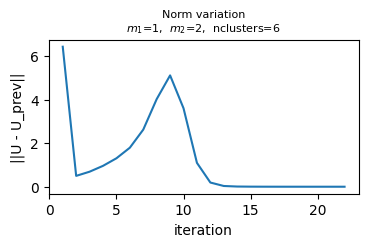

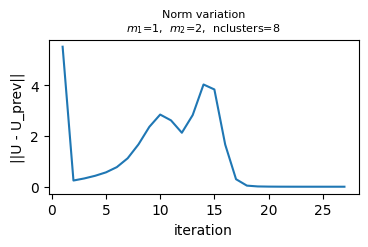

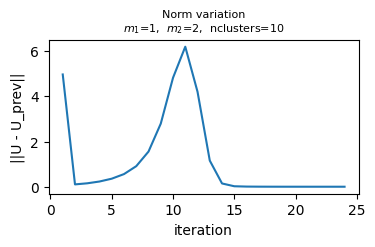

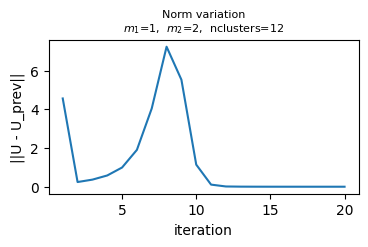

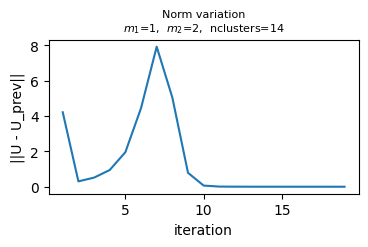

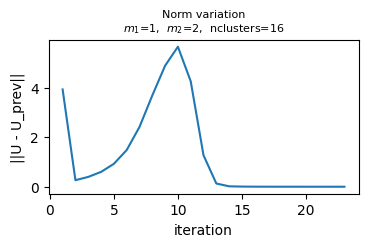

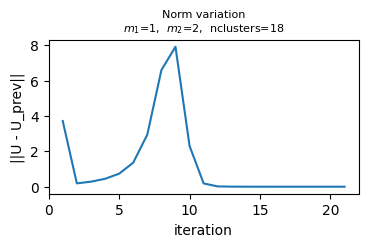

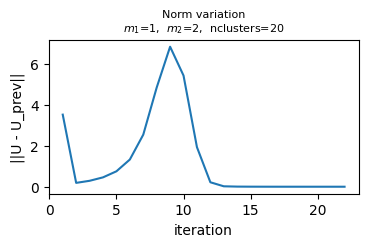

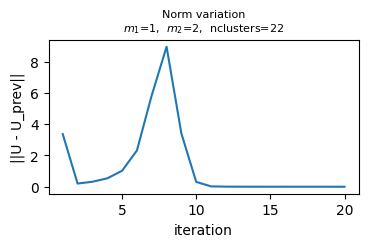

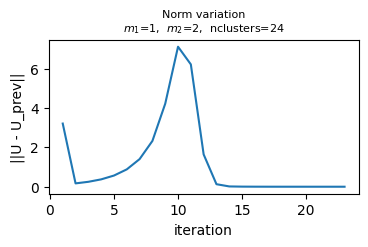

In [240]:
nclusters = 6
for i in range (10):
    U = fuzzyClustering(data_matrix, m1=1, m2=2, nclusters=nclusters, maxiter = 50, tol = 10**(-5))
    nclusters += 2

##### <font color='blue'>Effect of m1 </font>

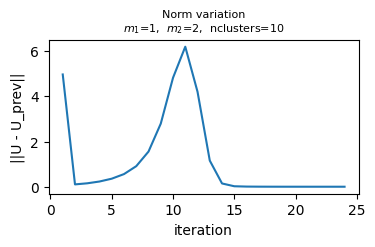

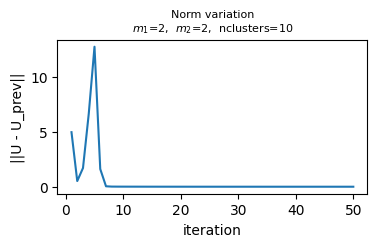

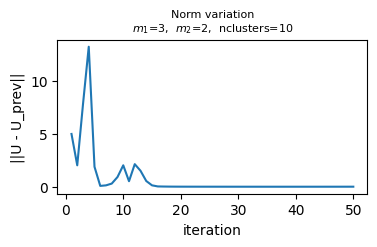

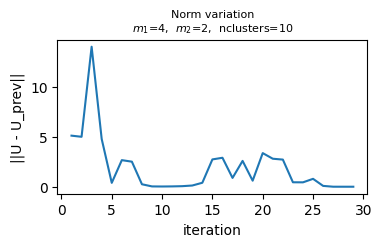

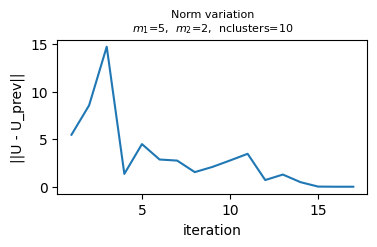

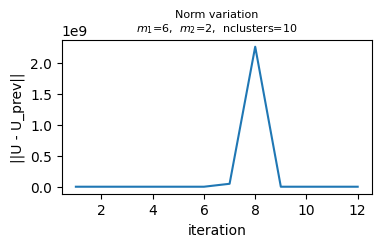

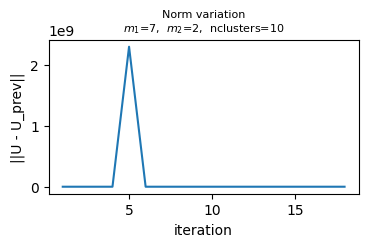

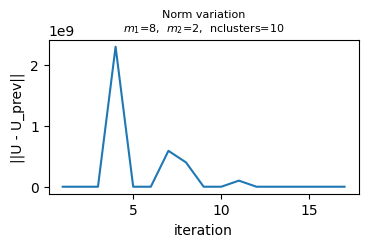

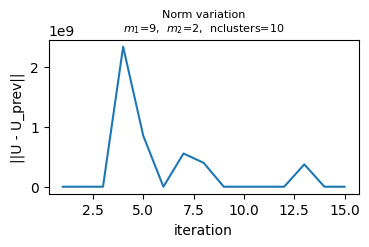

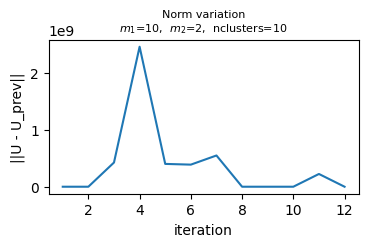

In [241]:
m1 = 1

for i in range (10):
    U = fuzzyClustering(data_matrix, m1, m2=2, nclusters = 10, maxiter = 50, tol = 10**(-5))
    m1 += 1

##### <font color='blue'>Effect of m2 </font>

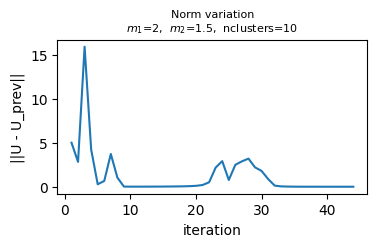

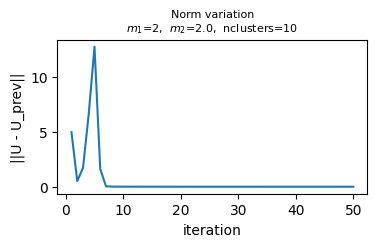

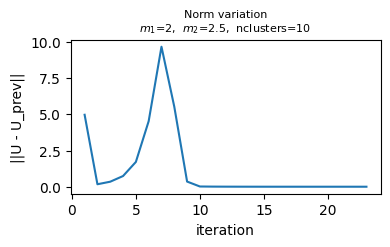

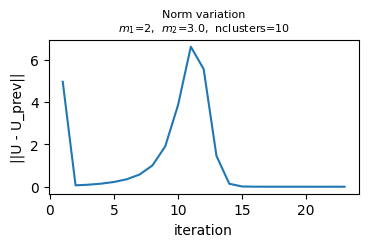

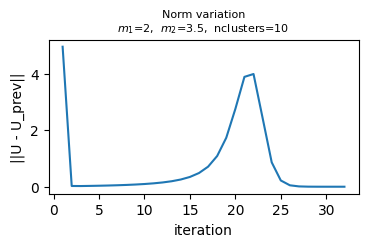

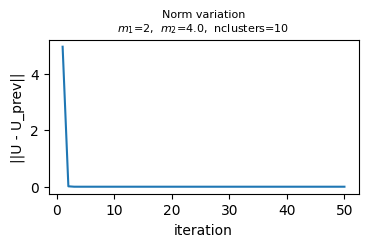

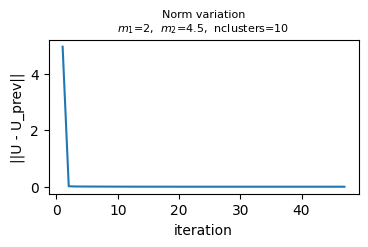

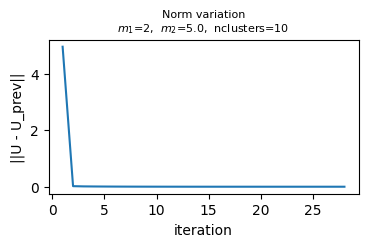

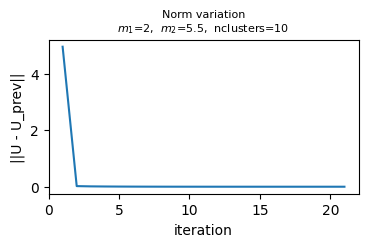

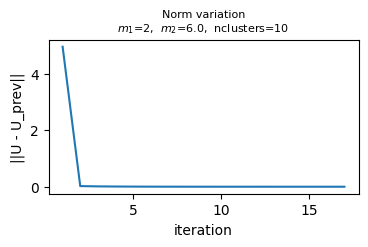

In [234]:
m2 = 1.5 
for i in range (10):
    U = fuzzyClustering(data_matrix, m1=2, m2=m2, nclusters = 10, maxiter = 50, tol = 10**(-5))
    m2 += 0.5

<font color='blue'>Could not observe a clear pattern in the effect of nclusters parameter to the norm variation.

In general, as m1 increases, oscillations occur in the norm variation. More stable variation can be observed when m1 is around 2.

For lower m2 values (<4), spikes can be observed in the norm variation. As m2 increases, the spikes disappear, and a rapid linear decrease followed by a slower linear decrease in the norm can be observed. Further increasing m2 reduces the rapidity of the initial norm reduction. </font>

In [226]:
def assign_crisp_labels(U):
    yfuzzy = np.argmax(U, axis=1)
    return yfuzzy

**Q7.** The Silhoutte score is a measure of how well the clustering has been done, the closer the score to $1.0$ the better the clustering. Refer to sklearn.metrics.silhouette_score. Determine the best choice of hyperparameters $m_1, m_2, \textrm{nclusters}$ through a grid search based on the silhoutte score as the evaluation metric. <font color='blue'>Report the best combination of hyperparameters.</font> For the grid search try $m_1 = 1.0, 1.2, \cdots, 3.0$, $m_2 = 1.2, 1.4, \cdots, 3.0$, $\textrm{nclusters} = 2, 3, \cdots, 15$.

In [227]:
# get arrays of m1, m2, and nclusters
m1_list = np.arange(1.0,3.2,0.2)
m2_list = np.arange(1.2,3.2,0.2)
nclusters_list = np.arange(2,16,1)

para = np.array(list(itertools.product(m1_list, m2_list, nclusters_list))) #all possible combinations of m1,m2 and nclusters

best_score = 0 #tracks the highest silhoutte score

print(para.shape)

for comb in para:
    U = fuzzyClustering(data_matrix, m1=comb[0], m2=comb[1], nclusters= int(comb[2]), maxiter = 50, tol = 10**(-5), visualize=False) # find membership matrix
    yfuzzy = assign_crisp_labels(U)
    score = silhouette_score(data_matrix, yfuzzy) # calculate score

    #checks if the current score is better
    if score>best_score:
        best_score = score
        best_comb = comb.copy()

print('best_comb: ',best_comb, 'best_score: ',best_score)

(1540, 3)
best_comb:  [ 2.4  1.6 15. ] best_score:  0.9585885646287973


<font color='blue'> Therefore, the best combination is

    m1 = 2.4

    m2 = 1.6

    nclusters = 15
</font>

**Q8.** For the best combination of hyperparameters run the following visualization function with different values for $0 \leq f_1 < f_2 < \textrm{nclusters}$. <font color='blue'>What do you see? Explain the purpose of the code and what you would expect through this?</font>

In [230]:
def visualizeClusters2D(X, yfuzzy, f1, f2):
    colorlist = ['black', 'gray', 'red', 'sienna', 'green', 'blue', 'gold', 'darkorange', 'olive', 'lavendar', 'salmon', 'teal', 'pink', 'magenta', 'tan', 'wheat']

    plt.figure(figsize=(3,2))
    
    for i in range(8):
        plt.scatter(X[yfuzzy == i, f1], X[yfuzzy == i, f2], color = colorlist[i])
        plt.title(f'f1={f1} , f2={f2}')

    plt.show()


data_matrix shape: 10


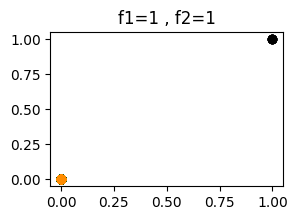

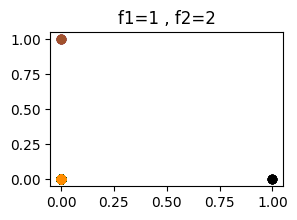

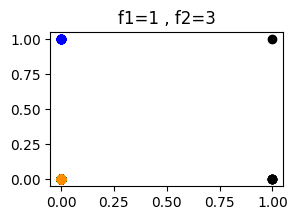

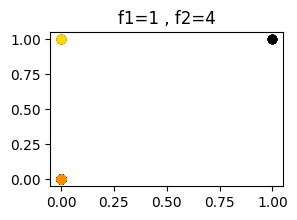

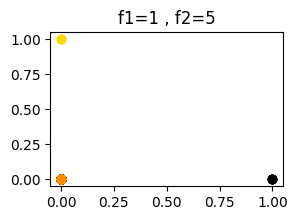

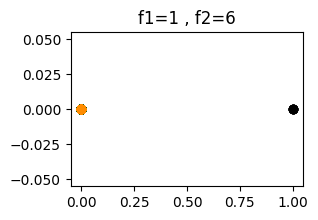

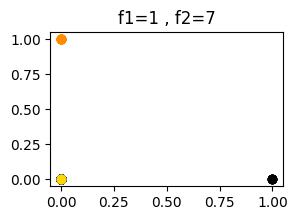

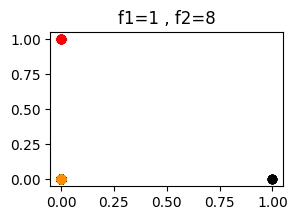

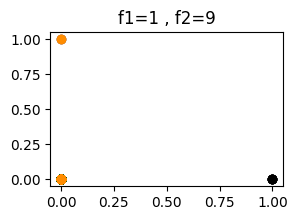

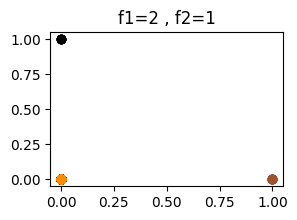

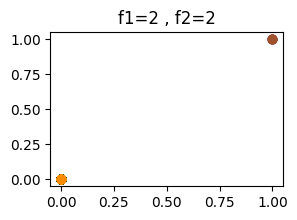

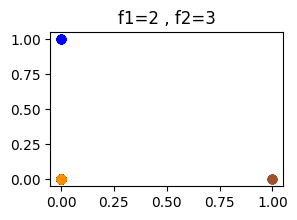

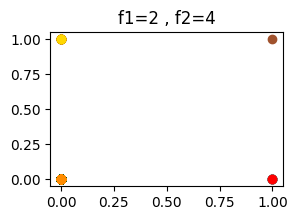

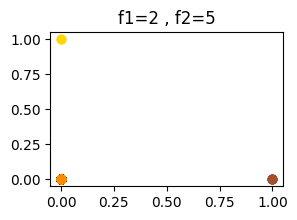

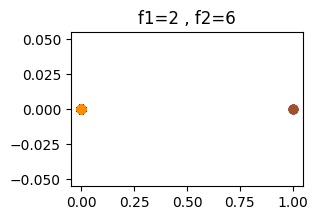

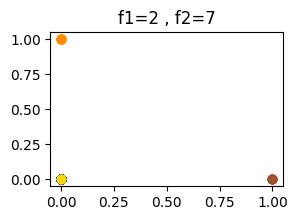

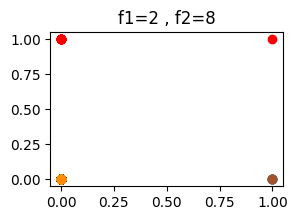

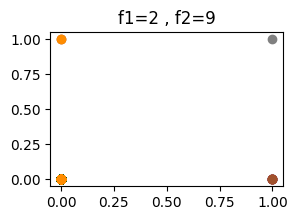

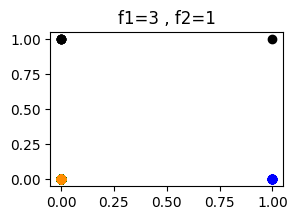

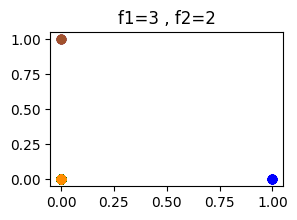

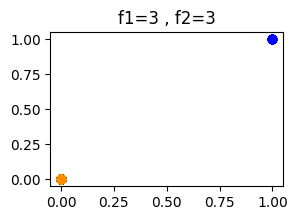

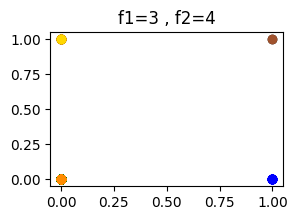

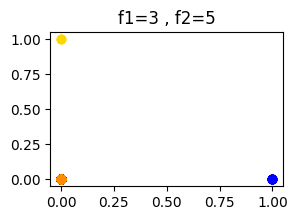

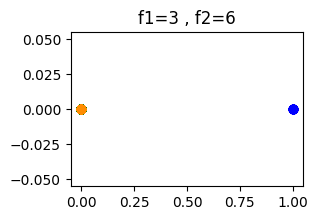

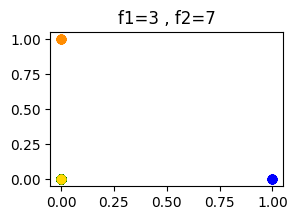

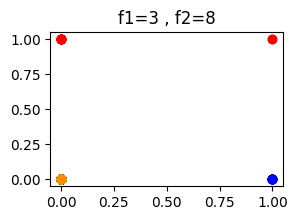

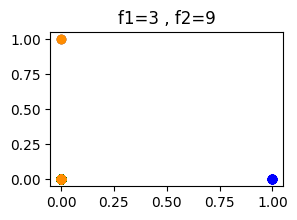

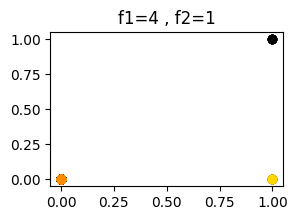

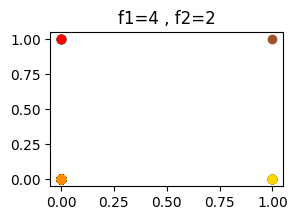

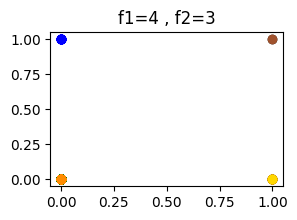

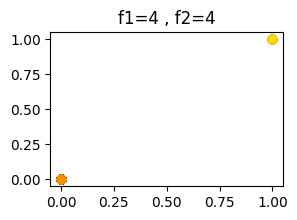

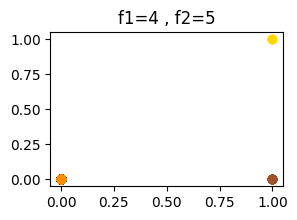

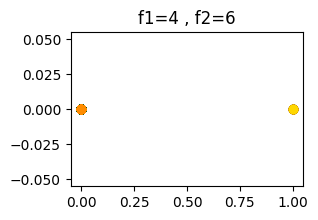

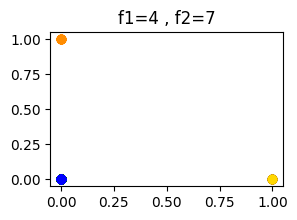

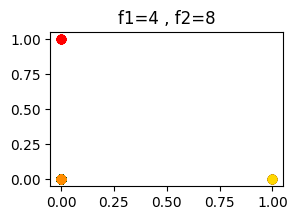

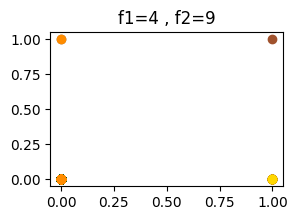

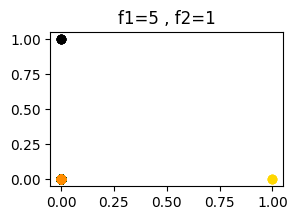

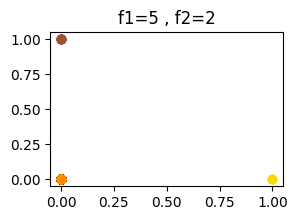

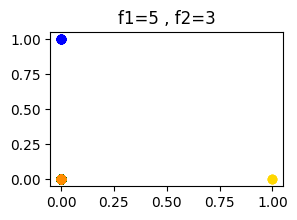

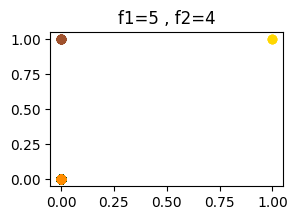

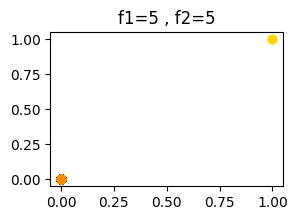

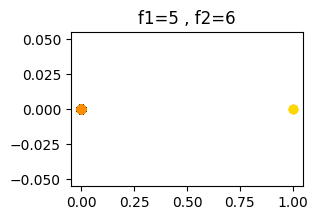

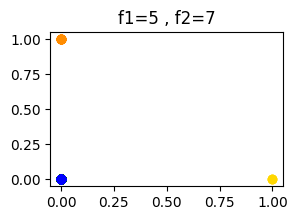

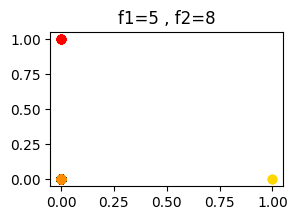

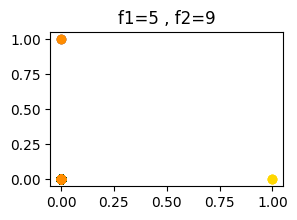

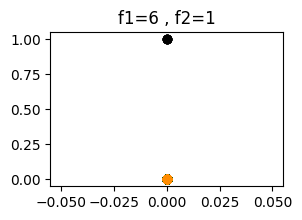

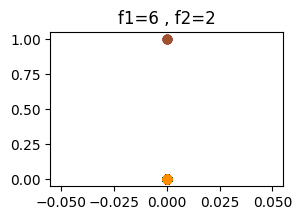

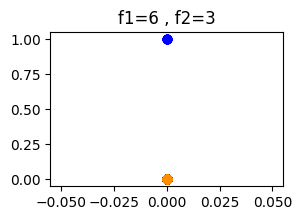

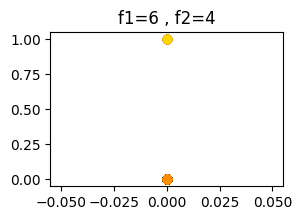

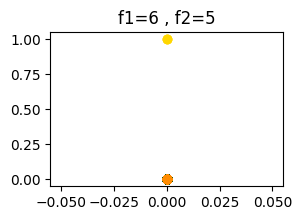

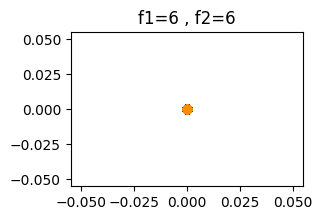

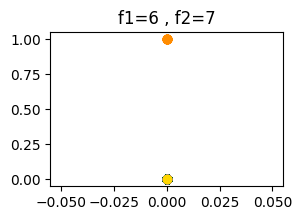

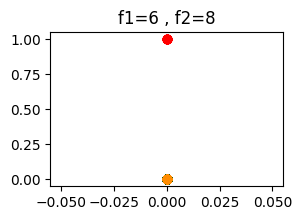

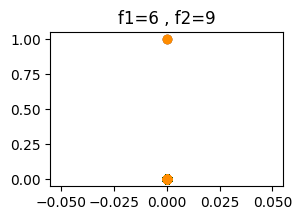

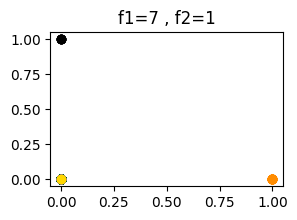

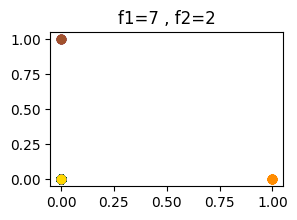

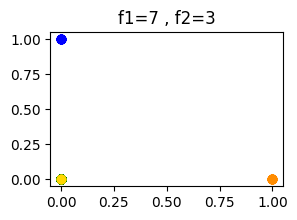

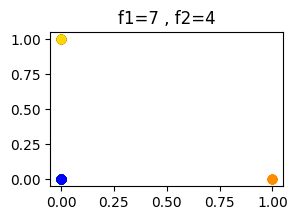

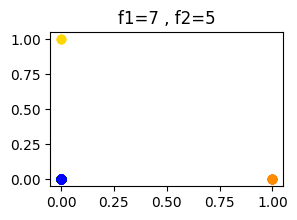

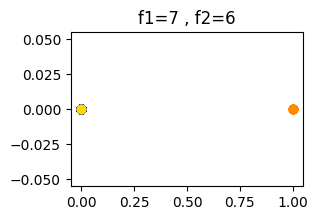

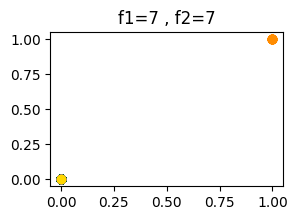

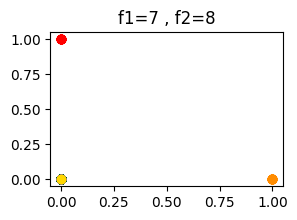

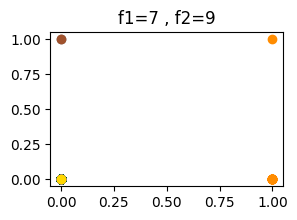

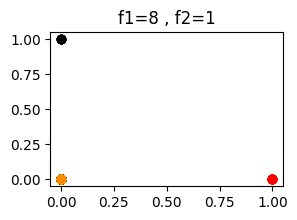

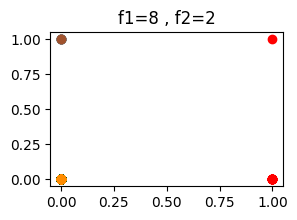

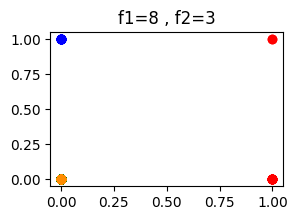

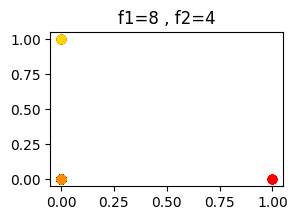

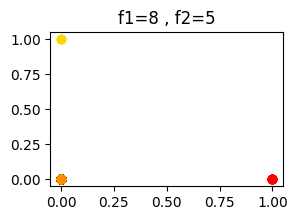

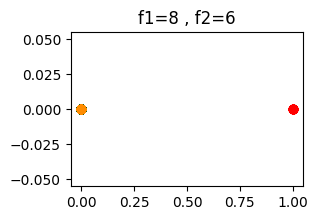

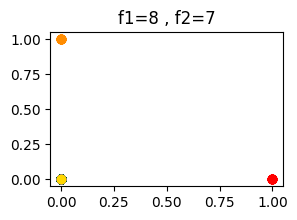

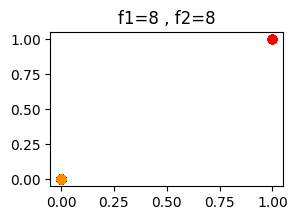

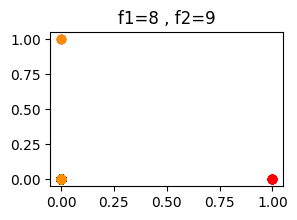

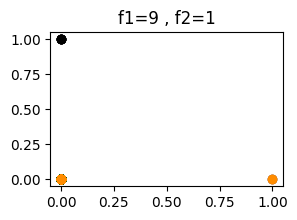

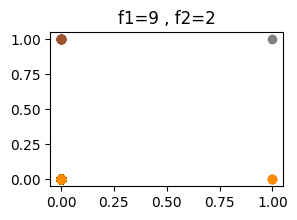

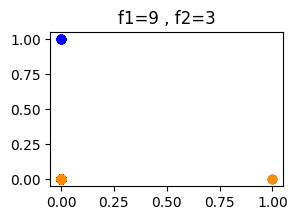

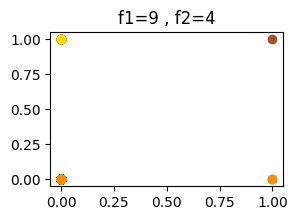

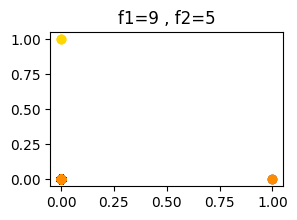

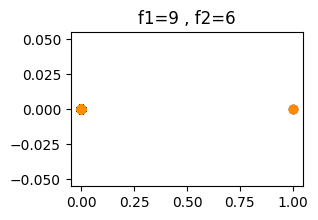

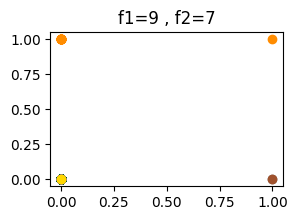

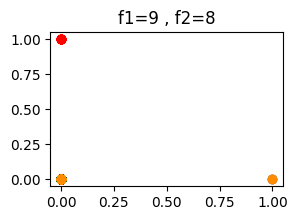

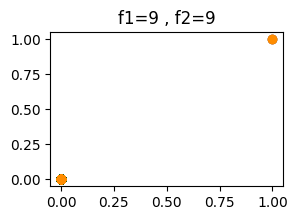

In [231]:
U = fuzzyClustering(data_matrix, m1=2.4, m2=1.6, nclusters= 15, maxiter = 50, tol = 10**(-5), visualize=False)
yfuzzy = assign_crisp_labels(U)

_,f_limit = data_matrix.shape  #find the upper bound for features

f_list=np.arange(1,f_limit,1)
para = np.array(list(itertools.product(f_list, f_list))) # get all the possible combinations of f1 and f2

for values in para:
    visualizeClusters2D(data_matrix, yfuzzy, f1=values[0], f2=values[1])


 <font color='blue'>
 
 The above code helps figuring out the feature pairs which are most relevant for a better clustering.

 From the plots following templates could be observed.
    1. one dot at the center of the plot

    2.  a. two dots at the opposite corners of the plot
        b. two dots to the middle of the vertical faces of the plot
        c. two dots to the middle of the horizontal faces of the plot

    3. three dots at three corners of the plot

    4. four dots at the four corners of the plot

One dot means that the clustering is very poor. Plots with only two dots also reflect poor clustering. Three dots at three corners suggests moderately good clustering.

In 4 dots scenario, two main differences could be observed within them. In some 4 dot plots multiple corners have the same colour dots. Rest of the 4 dot plots consist of 4 unique colour dots.

Having the same colour dot at opposite corners likely means that the corresponding clusters are spread out along a diagonal but are not sufficiently distinct from each other in the feature space. This implies that the clusters overlap significantly and are not well-separated by the selected features. Here the two clusters are not distinguishable using the f1 and f2 features alone, making this pair less effective for visualization.
Having same colour dots at the adjacent corners suggests that these clusters overlap in one direction (or dimension), leading to poor separation. Here the features may be capturing the same underlying variation in the data, leading to poor distinction between the clusters.

Therefore, the plots with 4 distict colours at the four courners correspond to the best pair of f1 and f2.

According to the plots, 

    a. f1=2 , f2=4

    b. f1=3 , f2=4

    c. f1=4 , f2=2

    d. f1=4 , f2=3
    
have shown better clustering results

</font>


**Q9.** Load (to a pandas dataframe) the actual dataset (SMData.csv) from which the previous dataset was cleaned out. Match each entry in this dataset with the labels you found out through clustering using the best combination of hyperparameters. Go through a few of those clustered entries and notice any patterns (or common sentiment) in the text (the "Text" column of this dataset) of each entry within clusters vs outside the clusters. The label of the $i$th entry in the dataset $= \textrm{yfuzzy}[i]$. <font color='blue'>Explain any observations. Based on your observations, is the clustering successful?</font>

In [208]:
new_dataframe = pd.read_csv('C:/Users/ASUS VivoBook/OneDrive - University of Moratuwa/Desktop/neural networks project/SMData.csv')

new_dataframe['cluster_label']= yfuzzy

for label in new_dataframe['cluster_label'].unique():
    print(f"Cluster {label}:")
    cluster_texts = new_dataframe[new_dataframe['cluster_label'] == label]['Text']

    # Display first few entries
    print(cluster_texts.head())
    print("\n" + "-"*50 + "\n")

Cluster 7:
0      Enjoying a beautiful day at the park!        ...
22     Productive day ticking off my to-do list.    ...
34     Winter sports day at the local park.         ...
42     Feeling accomplished after a productive day. ...
59     An amusing incident brightened up my day!    ...
Name: Text, dtype: object

--------------------------------------------------

Cluster 4:
1     Traffic was terrible this morning.           ...
2     Just finished an amazing workout! 💪          ...
3     Excited about the upcoming weekend getaway!  ...
6     Rainy days call for cozy blankets and hot coc...
8     Political discussions heating up on the timel...
Name: Text, dtype: object

--------------------------------------------------

Cluster 8:
4      Trying out a new recipe for dinner tonight.  ...
7      The new movie release is a must-watch!       ...
10     Just published a new blog post. Check it out!...
13     New year, new fitness goals! 💪               ...
26     Learning a new language

<font color='blue'>Given below are observed common features of several clusters:

cluster 7: positive daily experiences and moments

cluster 11: contemplation of life’s emotional and existential aspects

cluster 12: describes emotionally charged experiences

cluster 1: focuses on emotional reflection during the night

cluster 14: explore joy in various forms and its contrasts

Based on these, it seems like the clustering has been successfully done.</font>